In [8]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

annot_path='/home/bule/projects/Dice/workspace/data/d6-dice/Annotations'
im_path = "/home/bule/projects/Dice/workspace/data/d6-dice/Images/"
images = []


        
# for filename in os.listdir(im_path):
#     img = cv2.imread(os.path.join(im_path, filename))
#     if img is not None:
#         images.append(img)

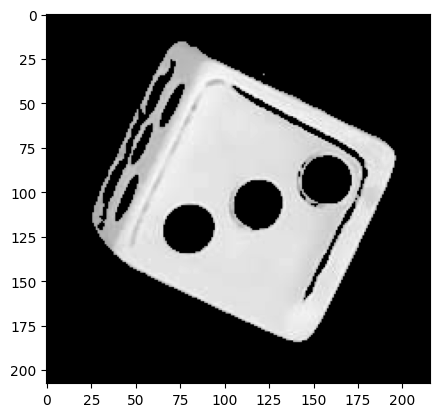

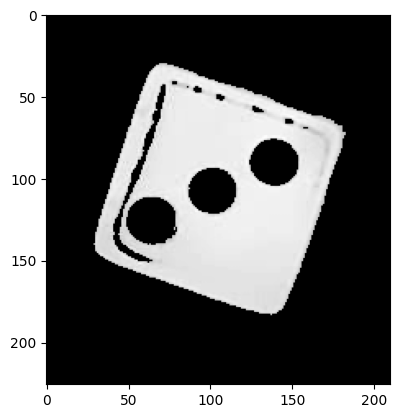

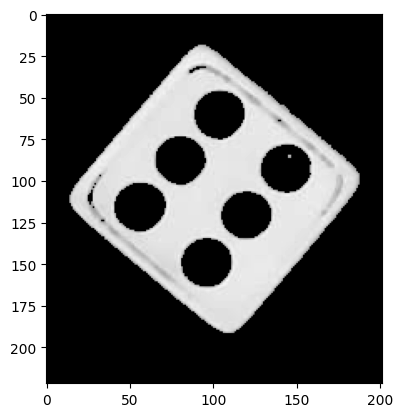

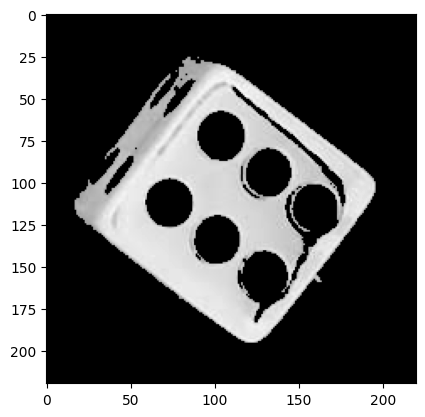

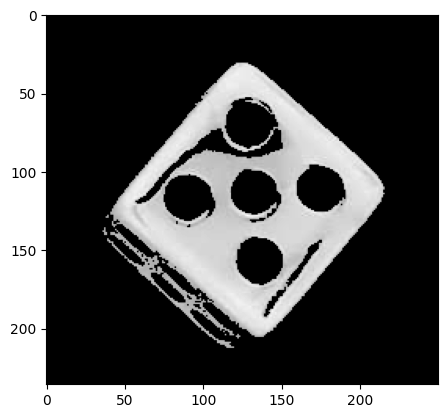

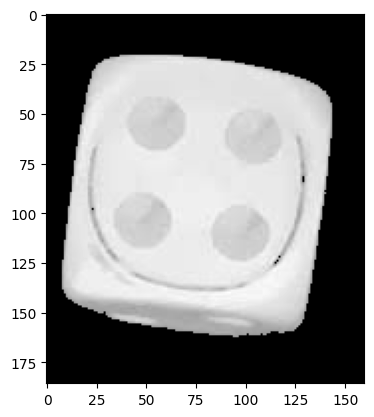

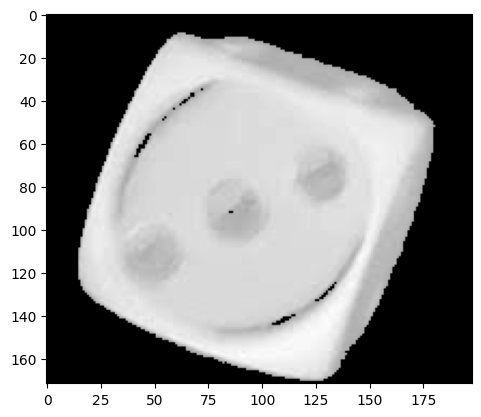

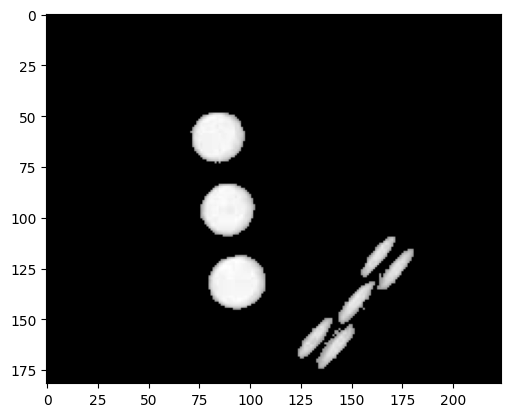

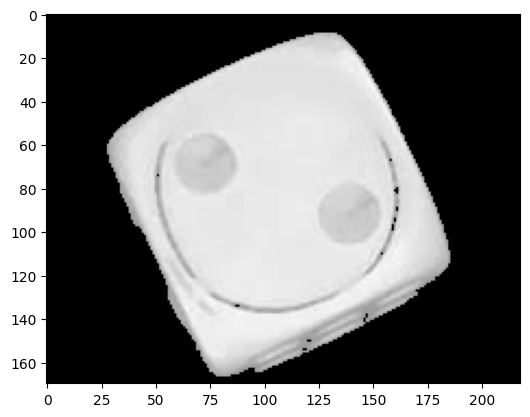

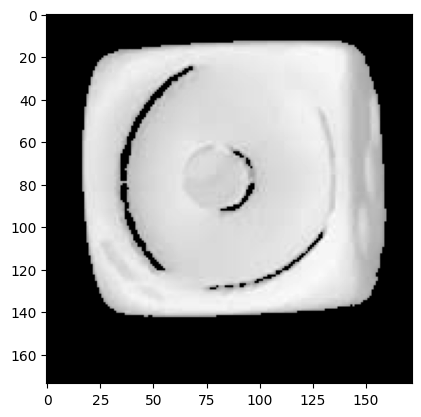

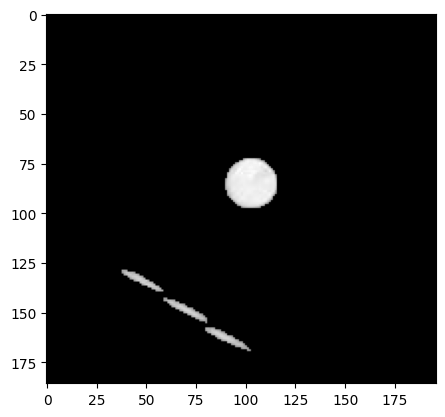

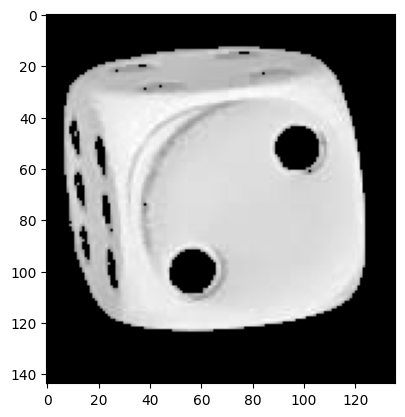

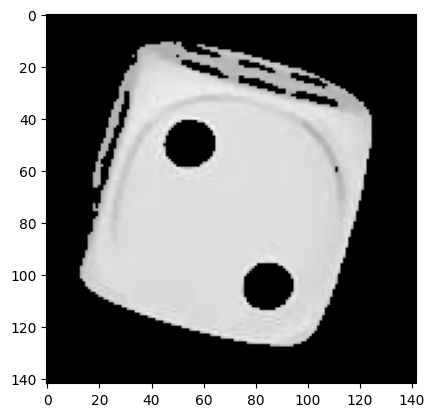

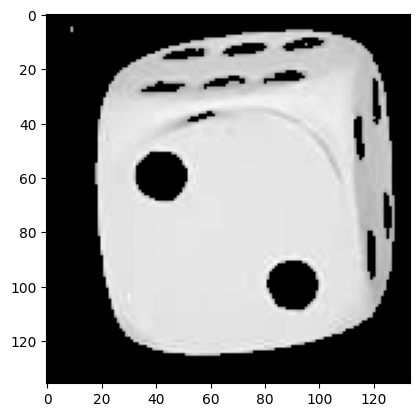

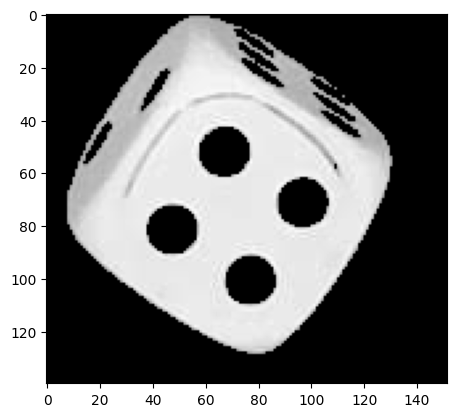

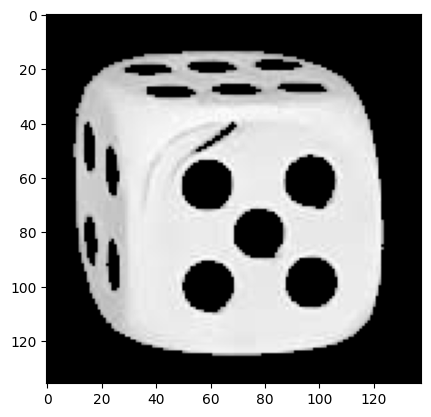

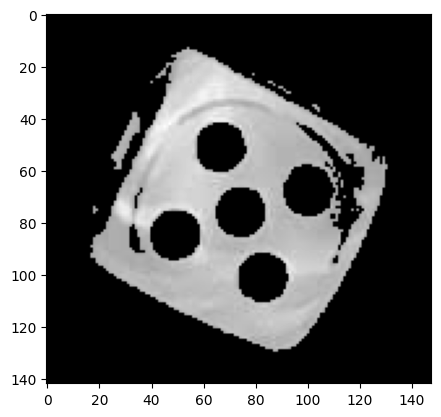

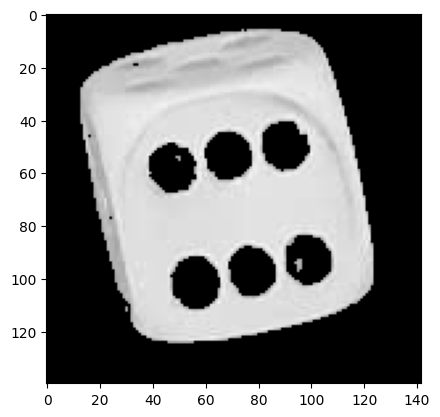

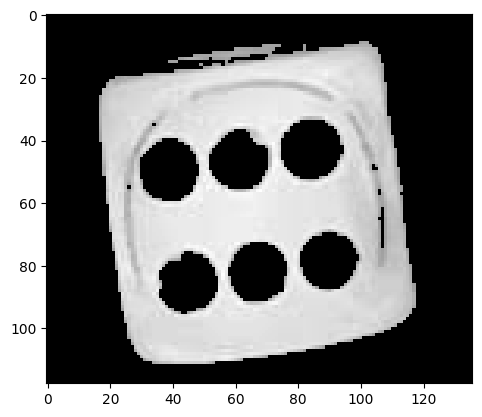

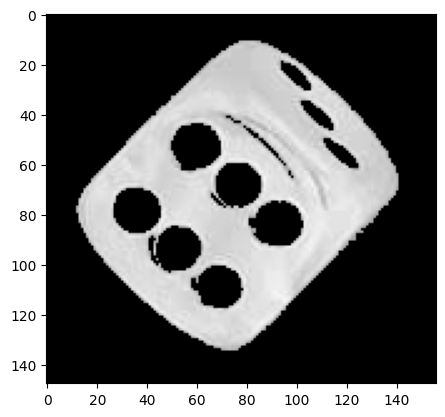

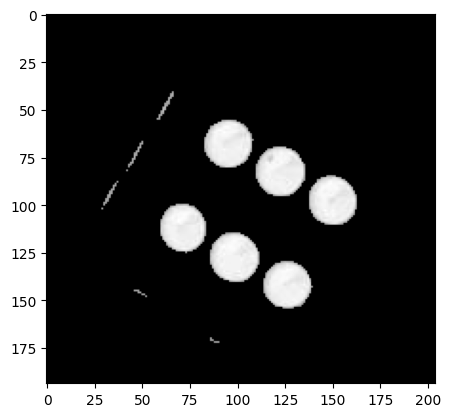

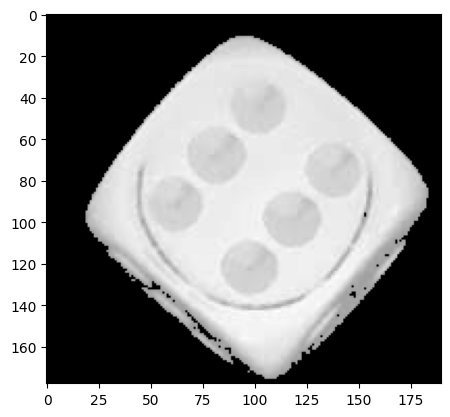

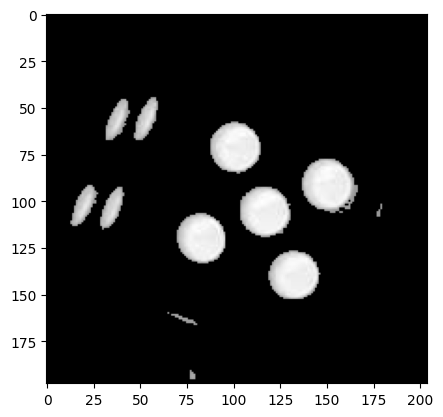

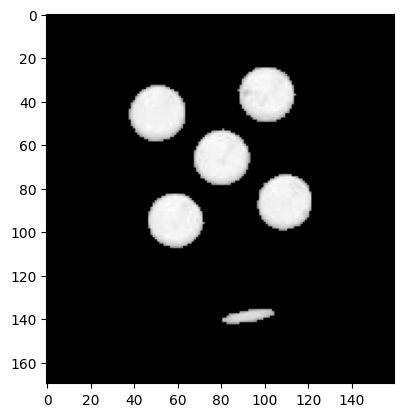

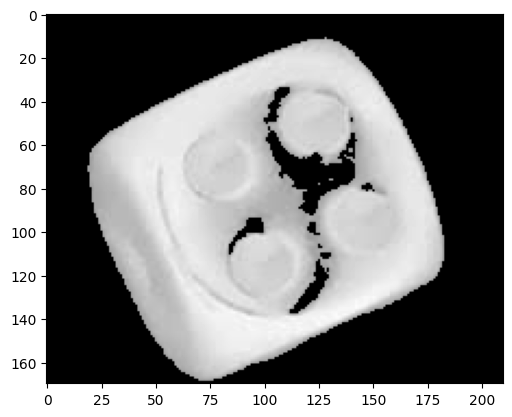

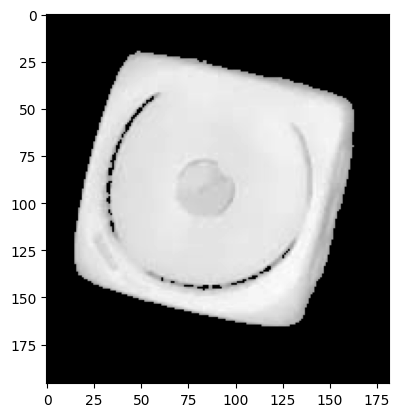

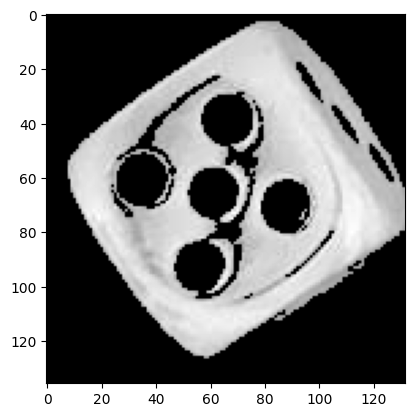

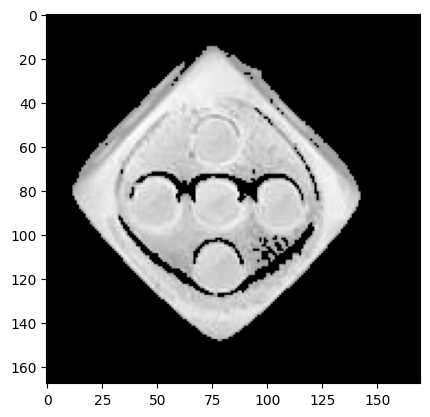

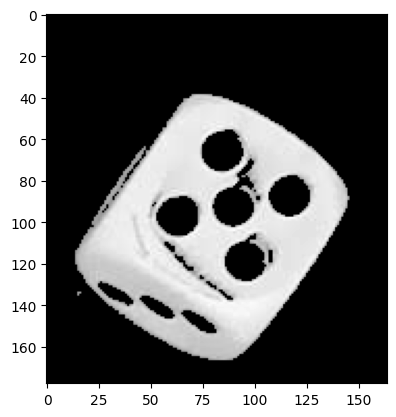

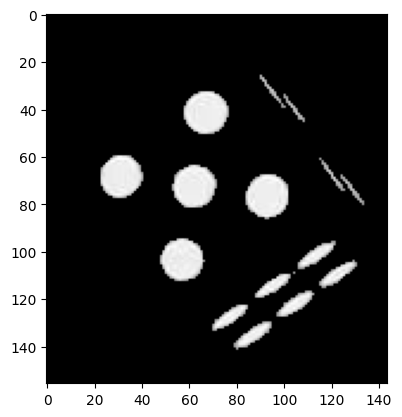

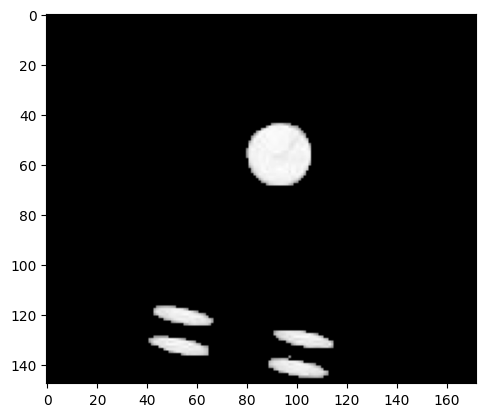

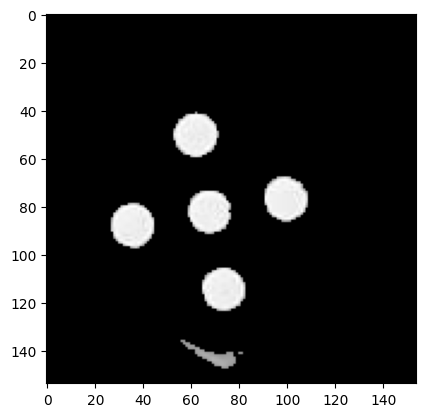

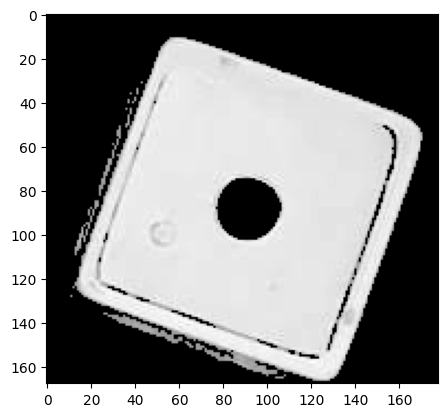

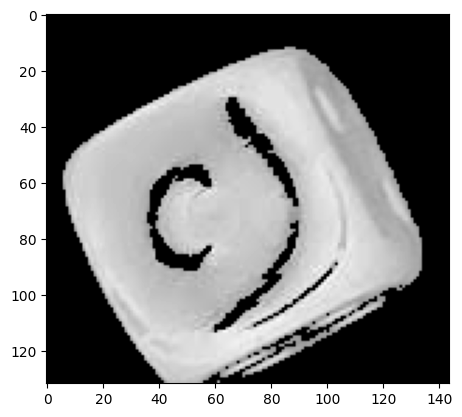

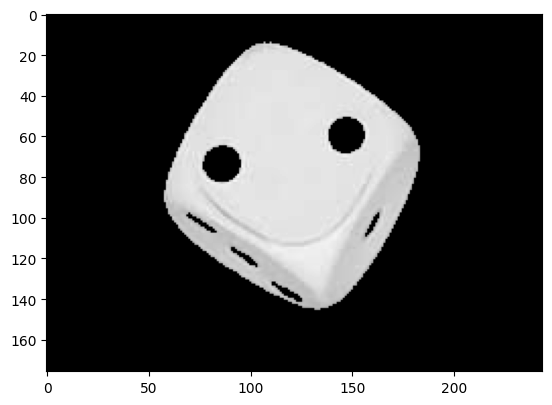

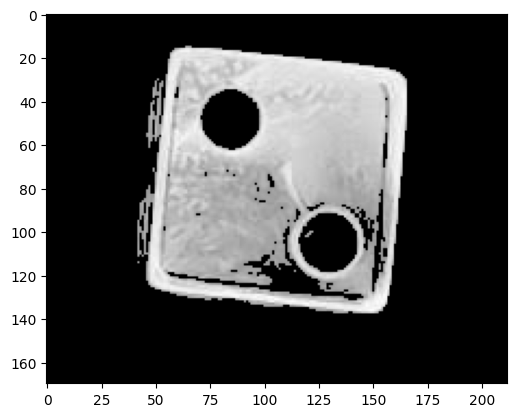

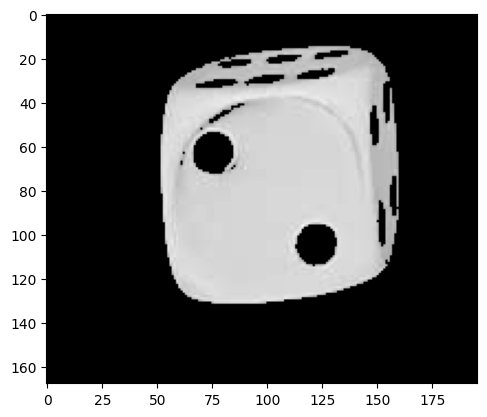

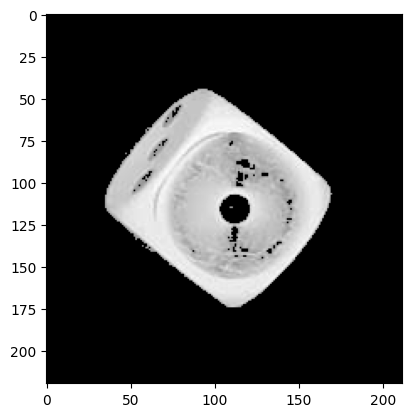

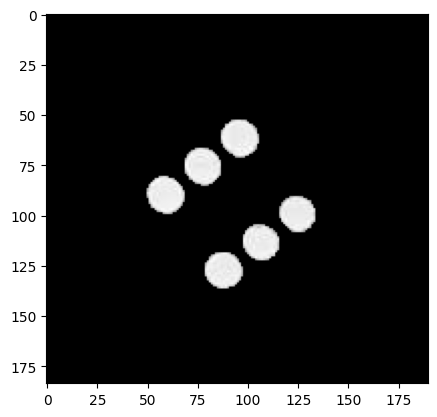

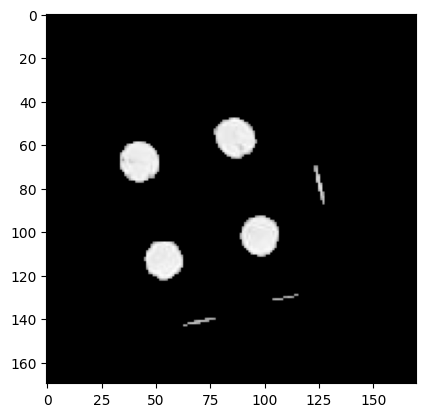

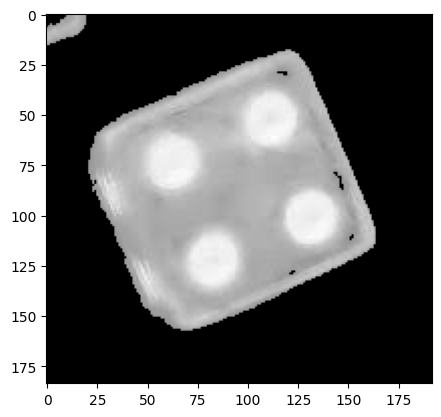

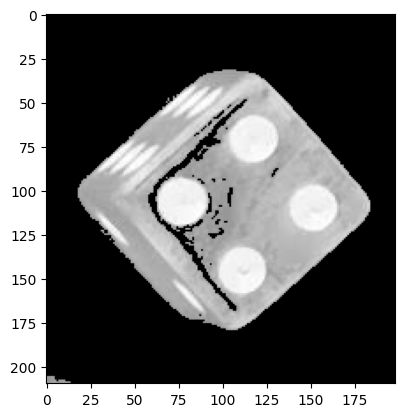

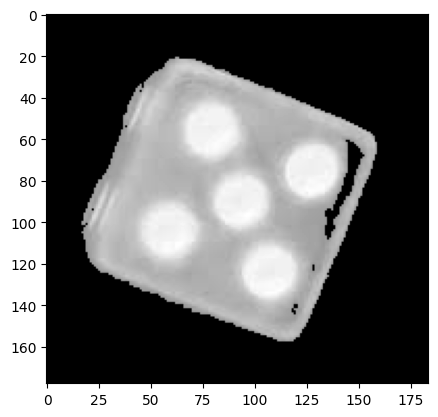

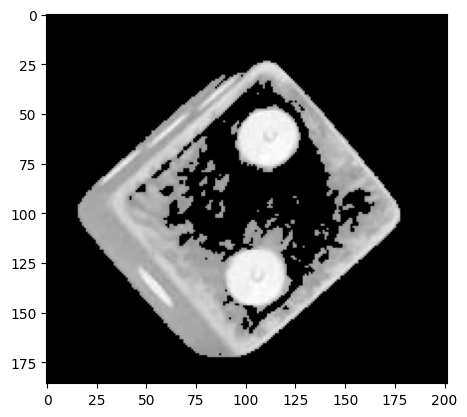

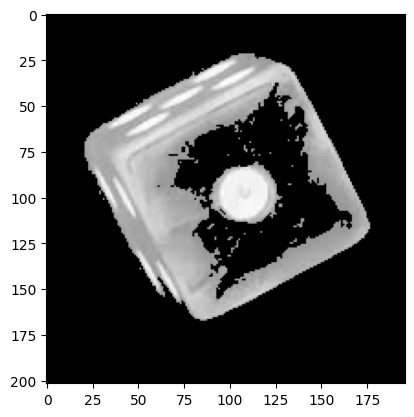

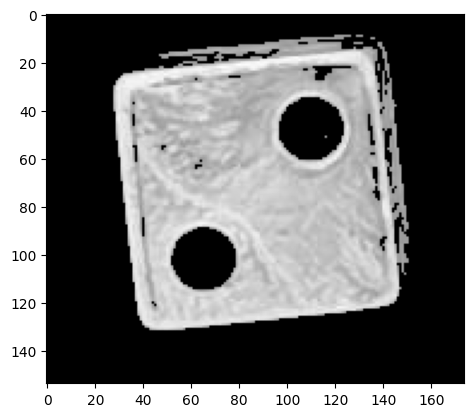

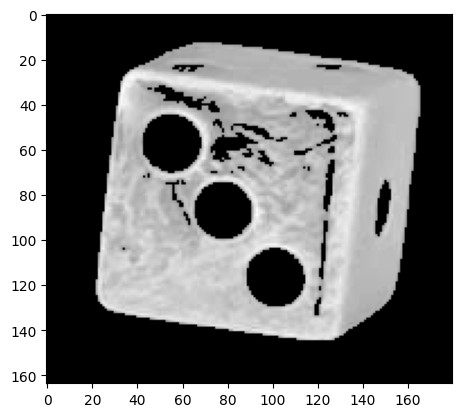

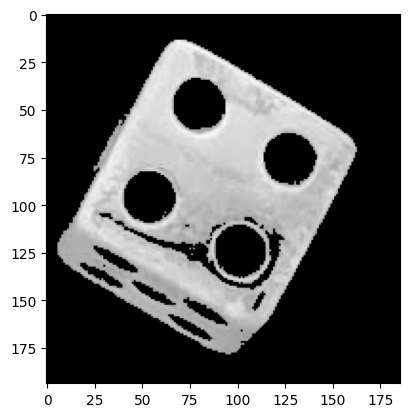

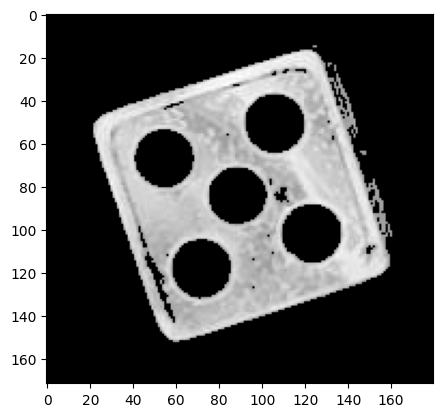

In [25]:
from PIL import Image, ImageOps
save_path = '/home/bule/projects/Dice/workspace/data/d6-dice/cropped_gray'

for filename in os.listdir(im_path)[:10]:
    anopath=os.path.join(annot_path, filename.replace('.jpg', '.txt'))
    img = cv2.imread(os.path.join(im_path, filename))
    df = pd.read_csv(anopath, header=0,sep=' ', names=['class', 'x_0', 'y_0', 'w', 'h'])
    
    anname=str(filename.replace('.txt','.png'))
    for i in range(len(df)):
        img_height, img_width, _ = img.shape
        dice_nr = int(df.iloc[i]['class'])
        x_0 = df.iloc[i]['x_0']
        y_0 = df.iloc[i]['y_0']
        w = df.iloc[i]['w']
        h = df.iloc[i]['h']
        img_height, img_width, _ = img.shape
        x_pixel = int(x_0 * img_width)
        y_pixel = int(y_0 * img_height)
        w_pixel = int(w * img_width)
        h_pixel = int(h * img_height)

        half_w_pixel = int(0.5 * w_pixel)
        half_h_pixel = int(0.5 * h_pixel)

        cropped_img = img[y_pixel - half_h_pixel:y_pixel + half_h_pixel, x_pixel - half_w_pixel:x_pixel + half_w_pixel]
    
        image=cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
        
        
        
        #image=cv2.Canny(image, 50, 100)
        
        inverted_image = ImageOps.invert(Image.fromarray(image))

        # Convert the inverted image back to a numpy array
        inverted_array = np.array(inverted_image)

        # Threshold the inverted image
        threshold = 150
        inverted_array[inverted_array < threshold] = 0

        # Display the thresholded inverted image using Matplotlib
        plt.imshow(inverted_array, cmap='gray')
        plt.show()
        image = Image.fromarray(image)
        #image.save(os.path.join(save_path,str(dice_nr+1),f'dice{dice_nr+1}_{i}_{anname}'))
    

In [ ]:
import random
def remove_range(hsv_img,low,high):
    '''
    removes a certain range of values on an image and retruns rgb image
    img:hsv image
    low:lower bound e.g. [0,0,0]
    high:higher bound e.g. [255,255,255]
    '''
    bg_mask = cv2.inRange(hsv_img, low, high)
    dices_mask = cv2.bitwise_not(bg_mask)
    img=cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return cv2.bitwise_and(img, img, mask=dices_mask)


def get_cropped(orig_gray,img):
    '''
    returns cropped images of the dices
    img:rgb image
    orig_gray:gray image orignal to crop from 
    '''
    gray_img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(gray_img, connectivity=8)
    output_image = np.zeros_like(gray_img)
    for i in range(1, num_labels):  # Start from 1 to ignore the background component
        if stats[i, cv2.CC_STAT_AREA] >= 50:
            output_image[labels == i] = 255  # Keep this connected component
    binary_mask = np.uint8(output_image > 0)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cropped = []
    hull_mask = np.zeros_like(binary_mask)
    # Loop over each contour
    for contour in contours:
        hull = cv2.convexHull(contour)
        cv2.drawContours(hull_mask, [hull], -1, (255), thickness=cv2.FILLED)
        x, y, w, h = cv2.boundingRect(hull)
        orig_gray_i=orig_gray.copy()
        orig_gray_i[hull_mask==0]=0
        cropped_image = orig_gray_i[y:y+h, x:x+w]
        cropped.append(cropped_image)
    return cropped , hull_mask


def get_white_red(img):
    '''
    img: opencv bgr array 
    
    returns: list of cropped red and white dice images in grayscale
    '''
    # Original imag to grayscale and hsv
    orig_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # remove background -> white and red, only take the red ones
    rgb_nogreen=   remove_range(hsv_image,np.array([40, 0, 0]),np.array([90, 255, 255])) #rbg
    rgb_red = remove_range(cv2.cvtColor(rgb_nogreen, cv2.COLOR_RGB2HSV), np.array([30, 0, 0]), np.array([160, 255, 255]))
    
    # get cropped images for red  and the mask of the red die
    cropped_img_red , hull_mask_red =get_cropped(orig_gray,rgb_red)

    # remove red dice from the image
    rgb_nored = rgb_nogreen.copy()  
    rgb_nored[hull_mask_red == 255] = 0

    cropped_img_white, _ = get_cropped(orig_gray,rgb_nored)

    return cropped_img_red,cropped_img_white


def model_dummy(img):
    '''
    dummy model that returns the number of red and white dices
    mimics:  model.predict(img)
    '''
    return random.randint(1, 6)


def rerun_criterion(img_list):
    '''
    img_list: list of opencv i channel images
    returns: bool , True if criterion met else False
    '''
    criterion=True
    for img in img_list:
            if  ((img.shape[0] / img.shape[1]) > 1.4) or ((img.shape[1] / img.shape[0]) >  1.4):
                criterion = False
    return criterion


def get_singleframes(frame):
    cropped_img_red,cropped_img_white = get_white_red(frame)
    return cropped_img_red + cropped_img_white
    

def main_dice(frame):
    '''
    img: opencv bgr array 
    returns: number of red and white dices, if criterion met bool
    '''
    cropped_img_red,cropped_img_white = get_white_red(frame)
    
    # check criterion
    if not rerun_criterion(cropped_img_red) or not rerun_criterion(cropped_img_white):
        return _ , False    
    
    resdict={"red_dice":[],"white_dice":[]}
    
    for img in cropped_img_red:
        resdict["red_dice"].append(model_dummy(img))
    for img in cropped_img_white:
        resdict["white_dice"].append(model_dummy(img))  
        
    return resdict, True

